In [1]:
# Run if working locally
%load_ext autoreload
%autoreload 2
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sqlite3
from sqlite3 import Error
import pickle
import os, sys
import config

config.root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, config.root_path)

from src.dataset.dataset import RawData
from src.dataset.qmsum_preprocessing import (
    tokenize,
    clean_sentence,
    preprocess_text_segmentation,
    format_data_for_db_insertion,
)
from db.dbv2 import Table, AugmentedTable, TrainTestTable
import pprint

<IPython.core.display.Javascript object>

In [3]:
config.root_path

'/Users/amitmaraj/Documents/PhD/context-encoder-qmsum'

<IPython.core.display.Javascript object>

In [4]:
from src.bertkeywords.src.similarities import Embedding, Similarities
from src.bertkeywords.src.keywords import Keywords

<IPython.core.display.Javascript object>

In [5]:
pp = pprint.PrettyPrinter(indent=4)
keywords_lib = Keywords()
similarities_lib = Similarities("bert-base-uncased")
embedding_lib = Embedding(similarities_lib.model, similarities_lib.tokenizer)

Metal device set to: Apple M2


2023-02-12 19:08:05.369149: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-12 19:08:05.369167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-12 19:08:07.857284: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-12 19:08:07.877548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-12 19:08:08.583263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

In [6]:
dataset_type = "committee"
table = Table(dataset_type)
augmented_table = AugmentedTable(dataset_type)
train_test_table = TrainTestTable(dataset_type)

<IPython.core.display.Javascript object>

In [7]:
data = table.get_all()

text_data = [x[1] for x in data]
text_labels = [x[2] for x in data]

<IPython.core.display.Javascript object>

In [15]:
samples = 25

for row, label in zip(text_data[:samples], text_labels[:samples]):
    keywords = keywords_lib.get_keyphrases(row)
    print(label, keywords)

1 [('camhs we', 0.2773), ('progress recognise', 0.2749), ('specialist camhs we', 0.2744), ('the specialist camhs', 0.2743), ('camhs we know', 0.2637)]
0 [('committee attention', 0.3302), ('draw the committee', 0.3045), ('committee attention to', 0.3013), ('the committee attention', 0.2807), ('committee has', 0.2716)]
1 [('good morning everyone', 0.3143), ('committee this morning', 0.301), ('education committee', 0.2944), ('programme thank', 0.2862), ('good morning', 0.2773)]
0 [('camhs we', 0.2773), ('progress recognise', 0.2749), ('specialist camhs we', 0.2744), ('the specialist camhs', 0.2743), ('camhs we know', 0.2637)]
0 [('committee attention', 0.3302), ('draw the committee', 0.3045), ('committee attention to', 0.3013), ('the committee attention', 0.2807), ('committee has', 0.2716)]
0 [('psychological therapies committee', 0.2854), ('therapy service', 0.2771), ('therapy service provision', 0.2768), ('therapies committee', 0.2753), ('national psychological therapies', 0.2742)]
0 [(

<IPython.core.display.Javascript object>

## Universal Sentence Encoder

In [9]:
# https://huggingface.co/Dimitre/universal-sentence-encoder

<IPython.core.display.Javascript object>

In [10]:
# @title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"  # @param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print("module %s loaded" % module_url)


def embed(input):
    return model(input)

2023-02-12 19:40:43.745594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


<IPython.core.display.Javascript object>

In [11]:
# @title Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be."
)
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join((str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

2023-02-12 19:40:50.164571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Message: Elephant
Embedding size: 512
Embedding: [0.008344453759491444, 0.00048083634465001523, 0.06595247238874435, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.0508086122572422, -0.016524318605661392, 0.01573779433965683, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.028332678601145744, -0.0558621771633625, -0.01294148899614811, ...]



<IPython.core.display.Javascript object>

In [12]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd"
    )
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")


def run_and_plot(messages_):
    print(messages_)
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)

<IPython.core.display.Javascript object>

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.', 'Will it snow tomorrow?', 'Recently a lot of hurricanes have hit the US', 'Global warming is real', 'An apple a day, keeps the doctors away', 'Eating strawberries is healthy', 'Is paleo better than keto?', 'How old are you?', 'what is your age?']


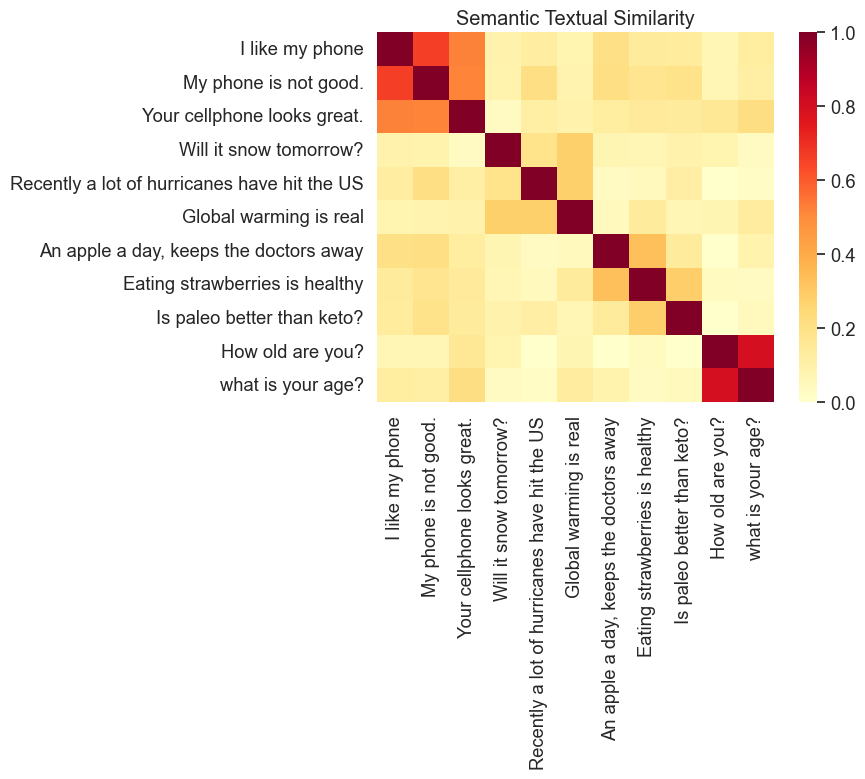

<IPython.core.display.Javascript object>

In [13]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",
    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",
    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",
    # Asking about age
    "How old are you?",
    "what is your age?",
]

run_and_plot(messages)

## USE with data

In [14]:
samples = 25
max_str_length = 30

for i, (row, label) in enumerate(zip(text_data[:samples], text_labels[:samples])):
    if i == 0:
        pass
    else:
        prev_string = text_data[:samples][i - 1]
        truncated_string = (
            (row[:max_str_length] + "..") if len(row) > max_str_length else row
        )
        truncated_prev_string = (
            (prev_string[:max_str_length] + "..")
            if len(prev_string) > max_str_length
            else prev_string
        )

        prev_string_embedding = embed([prev_string])
        current_string_embedding = embed([row])
        similarity = cosine_similarity(prev_string_embedding, current_string_embedding)

        print(f"{label}, {similarity}, {truncated_prev_string} <> {truncated_string}")

0, [[0.67885584]], thank you very much for that q.. <> thank you . and you referred t..
1, [[0.53249055]], thank you . and you referred t.. <> good morning , everyone , and ..
0, [[0.53933775]], good morning , everyone , and .. <> thank you very much for that q..
0, [[0.67885584]], thank you very much for that q.. <> thank you . and you referred t..
0, [[0.6490866]], thank you . and you referred t.. <> this is maybe about what the p..
0, [[0.36039567]], this is maybe about what the p.. <> okay , thank you . we 've got ..
0, [[0.20255809]], okay , thank you . we 've got .. <> thank you . good morning . in ..
0, [[0.5671687]], thank you . good morning . in .. <> yes , thanks very much . so , ..
0, [[0.33669013]], yes , thanks very much . so , .. <> thank you . i know , from my o..
0, [[0.37919328]], thank you . i know , from my o.. <> yes . i think that the thrust ..
0, [[0.50472623]], yes . i think that the thrust .. <> thank you . what are the outco..
0, [[0.00902405]], thank you . wha

<IPython.core.display.Javascript object>